In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/BRCA/"

In [ ]:
%pip install gseapy

In [ ]:
## import METABRIC patient data with BRCA subtype
import pandas as pd
df = pd.read_csv(path+"data_clinical_patient.txt", sep="\t", comment="#")
print(df.columns.tolist())

['PATIENT_ID', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY', 'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY', 'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS', 'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE', 'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY', 'RFS_MONTHS', 'RFS_STATUS']


In [ ]:
for i in df.columns.tolist():
    if 'type' in i.lower():
        print(i)

CLAUDIN_SUBTYPE
HISTOLOGICAL_SUBTYPE


In [ ]:
df = df[['PATIENT_ID','CLAUDIN_SUBTYPE']]
df.columns =['patient_id', 'Subtype']
df.head()

,patient_id,Subtype
0,MB-0000,claudin-low
1,MB-0002,LumA
2,MB-0005,LumB
3,MB-0006,LumB
4,MB-0008,LumB


In [ ]:
## import METABRIC RNA data and filter for RNA 25 features
df_rna = pd.read_csv(path+"data_mrna_illumina_microarray.txt", sep="\t", comment="#")
df_rna_n = df_rna[df_rna.Hugo_Symbol.isin(["ZNF703", "CKS1B", "ABAT", "CDC45", "B3GNT5", "ZNF552", "GABRP", "KRT16", "ANKRD30A", "PPP1R14C", "MTHFD1L", "RFC4", "CDC25A", "ZNF454", "TTK", "POP1", "CCNA2", "CYP4B1", "ARSG", "CENPO", "GREB1", "DSCC1", "RGMA", "BCL11A", "MASTL"])]

In [ ]:
df_rna_t = df_rna_n.transpose()
# Set the first row as header
df_rna_t.columns = df_rna_t.iloc[0]

# Drop that header row from data
df_rna_t = df_rna_t[1:]
df_rna_t.head()

Hugo_Symbol,MASTL,ABAT,B3GNT5,ZNF454,CDC45,CDC25A,CCNA2,ARSG,POP1,DSCC1,...,GABRP,PPP1R14C,GREB1,TTK,ANKRD30A,RGMA,MTHFD1L,ZNF703,BCL11A,RFC4
Entrez_Gene_Id,84930,18,84002,285676,8318,993,890,22901,10940,79075,...,2568,81706,9687,7272,91074,56963,25902,80139,53335,5984
MB-0362,6.442063,6.58872,5.494441,5.44124,7.161815,5.969954,7.446908,7.442243,6.058241,5.652113,...,5.663693,5.356834,5.717272,6.439636,11.683678,7.466136,7.387612,5.800212,5.813964,7.938321
MB-0346,6.992497,5.886067,5.398318,5.389633,8.776913,6.62463,8.076702,7.286877,7.121548,6.534205,...,5.610676,7.817757,6.304642,6.806254,10.085667,6.569146,7.314139,5.558949,6.148479,8.400428
MB-0386,6.501598,5.414925,5.330081,5.61582,6.605329,5.586861,7.359897,6.773398,5.946788,6.100974,...,5.93767,5.611514,6.214088,6.251964,9.502052,6.97049,7.343528,5.842168,5.959839,8.17235
MB-0574,6.266299,7.064126,5.659823,5.628083,6.590372,5.494226,6.694025,7.997496,6.175443,5.856851,...,5.566003,5.272649,6.946909,6.712498,11.349427,6.59043,6.9938,6.036478,6.002407,8.670699


In [ ]:
### Generate the joint data covering BRCA subtypes and RNA features
df_merged = df.merge(df_rna_t, left_on="patient_id", right_index=True)
df_merged = df_merged[df_merged['Subtype'].isin(['LumA', 'LumB', 'Her2','Basal'])]

##### Enrich Analysis by Subset using METABRIC data and test if the pattern consistent with those from TCGA

In [ ]:
# df has columns: patient_id, Subtype, MASTL, ABAT, ...
# set patient_id as index
df_expr = df_merged.set_index("patient_id")

# make a map from sample ID → subtype
subtype_map = df_expr["Subtype"].to_dict()

# drop Subtype so only genes remain
df_expr = df_expr.drop(columns=["Subtype"])

# ssGSEA expects: rows = genes, columns = samples
data_for_ssgsea = df_expr.T
data_for_ssgsea = data_for_ssgsea.apply(pd.to_numeric, errors="coerce")


In [ ]:
import gseapy as gp

ss = gp.ssgsea(data=data_for_ssgsea,
               gene_sets=path+"rna_pathways2.gmt",
               sample_norm_method='rank',  # nonparametric approach
               outdir=None,
               verbose=True,
               min_size=5,
               scale=True,
               permutation_num=0)  # no permutation for ssGSEA

enrichment_scores = ss.res2d
enrichment_scores = enrichment_scores.set_index('Name')
enrichment_scores.index.name = 'patient_id'
enrichment_scores['Subtype'] = enrichment_scores.index.map(subtype_map)
enrichment_scores = enrichment_scores.dropna(subset=["Subtype"])

2025-11-23 21:56:12,467 [INFO] Parsing data files for ssGSEA...........................
2025-11-23 21:56:12,735 [INFO] 0056 gene_sets have been filtered out when max_size=500 and min_size=5
2025-11-23 21:56:12,735 [INFO] 0007 gene_sets used for further statistical testing.....
2025-11-23 21:56:12,736 [INFO] Start to run ssGSEA...Might take a while................


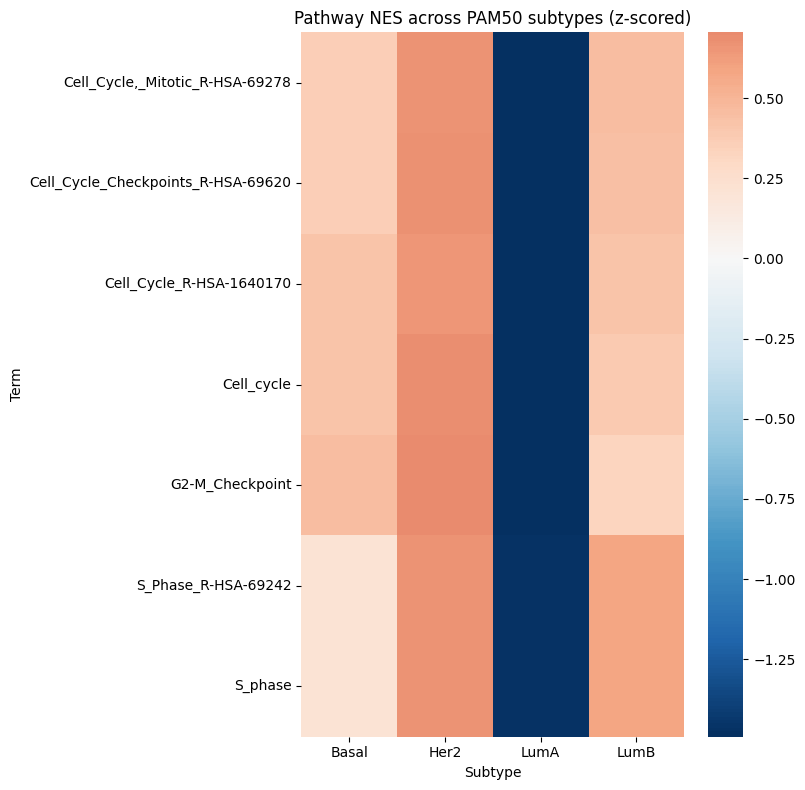

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: calculate every (Term, Subtype) average NES
pivot_df = enrichment_scores.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single pathway
pivot_df_z = pivot_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_z = pivot_df_z.astype(float).fillna(0)

# Step 3: heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(pivot_df_z, cmap="RdBu_r", center=0, annot=False)
plt.title("Pathway NES across PAM50 subtypes (z-scored)")
plt.tight_layout()
plt.show()

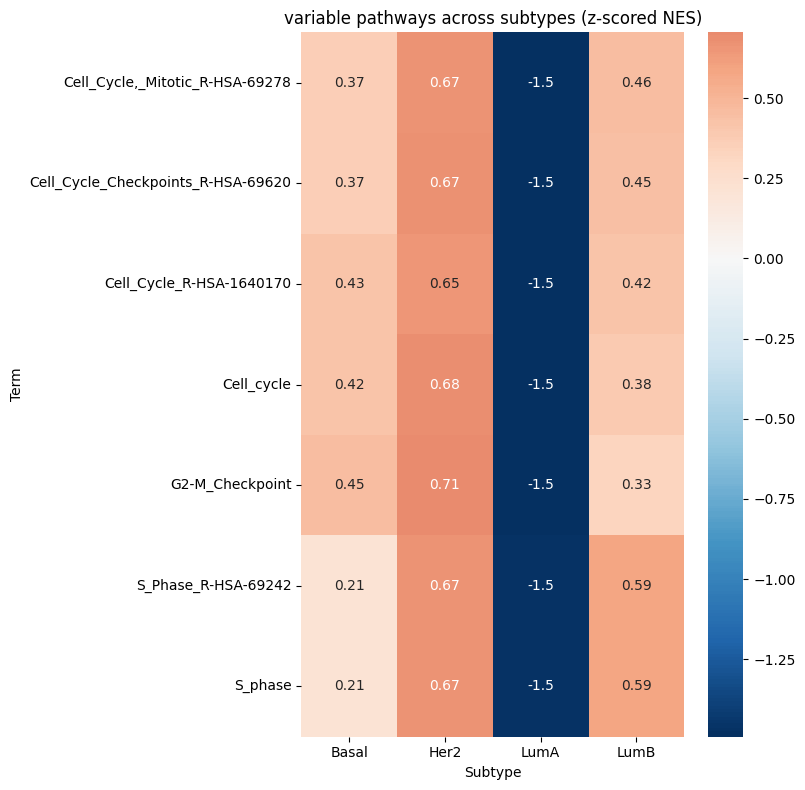

In [ ]:
# Get the top 20 path with largest NES variance
top_terms = enrichment_scores.groupby('Term')['NES'].std().sort_values(ascending=False).head(20).index.tolist()

# heatmap with the selected path
top_df_rna = enrichment_scores[enrichment_scores['Term'].isin(top_terms)]
pivot_df_rna = top_df_rna.groupby(['Term', 'Subtype'])['NES'].mean().unstack()

# Step 2: z-score standardize single path
pivot_df_rna_z = pivot_df_rna.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
pivot_df_rna_z = pivot_df_rna_z.astype(float).fillna(0)


# draw heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(pivot_df_rna_z, cmap="RdBu_r", center=0, annot=True)
plt.title("variable pathways across subtypes (z-scored NES)")
plt.tight_layout()
plt.show()

The Enrichment Analysis by Subtype Chart aligns with the one yielded using TCGA data

Scatter plot between METABRIC and TCGA enrich analysis by subtype

In [ ]:
metabric_matrix = enrichment_scores.pivot_table(
    index="Term", columns="Subtype", values="NES", aggfunc="mean"
)

In [ ]:
tcga_matrix = pd.read_csv(path+'tcga_enr_subtype.csv').set_index('Term')
common_terms = tcga_matrix.index.intersection(metabric_matrix.index)
tcga_common = tcga_matrix.loc[common_terms]
metabric_common = metabric_matrix.loc[common_terms]

subtypes = ["Basal", "Her2", "LumA", "LumB"]

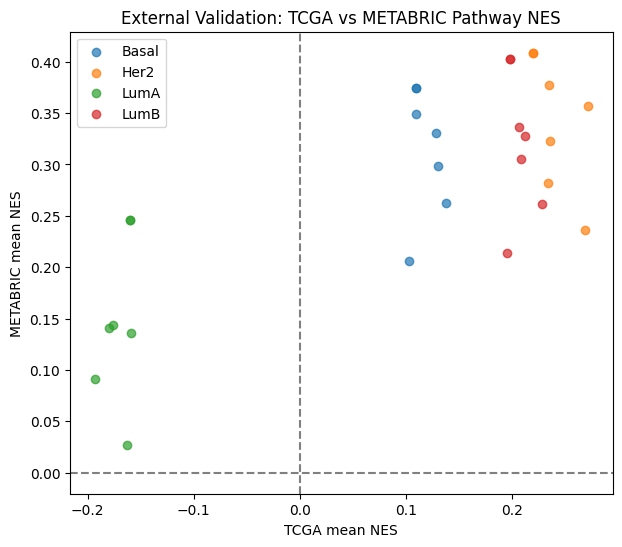

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

for subtype in subtypes:
    x = tcga_common[subtype]
    y = metabric_common[subtype]
    plt.scatter(x, y, alpha=0.7, label=subtype)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

plt.xlabel("TCGA mean NES")
plt.ylabel("METABRIC mean NES")
plt.title("External Validation: TCGA vs METABRIC Pathway NES")
plt.legend()

plt.show()

Average Value by Path Type

In [ ]:
def parse_gmt(gmt_file_path):
    """
    Reads a GMT file and returns a dictionary:
    {'Pathway_Name': ['Gene1', 'Gene2', ...]}
    """
    pathway_dict = {}
    with open(gmt_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            pathway_name = parts[0]
            # parts[1] is usually description (NA), genes start at parts[2]
            genes = parts[2:]
            pathway_dict[pathway_name] = genes
    return pathway_dict


In [ ]:
pathways = parse_gmt(path+'rna_pathways2.gmt')
all_genes = set([g for genes in pathways.values() for g in genes])

In [ ]:
pathway_scores = pd.DataFrame()
pathway_scores['Subtype'] = df_merged['Subtype']

print("Calculating scores for pathways found in GMT file...")
for pathway_name, genes in pathways.items():
    # Only use genes that actually exist in your METABRIC csv
    valid_genes = [g for g in genes if g in df_merged.columns]

    if len(valid_genes) > 0:
        # Score = Average Z-score of all genes in the pathway
        pathway_scores[pathway_name] = df_merged[valid_genes].mean(axis=1)
    else:
        print(f"  Skipping {pathway_name}: No matching genes found in CSV.")

Calculating scores for pathways found in GMT file...


/tmp/ipython-input-1004340981.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Subtype', y=pname, data=pathway_scores, palette="Set2")
/tmp/ipython-input-1004340981.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Subtype', y=pname, data=pathway_scores, palette="Set2")


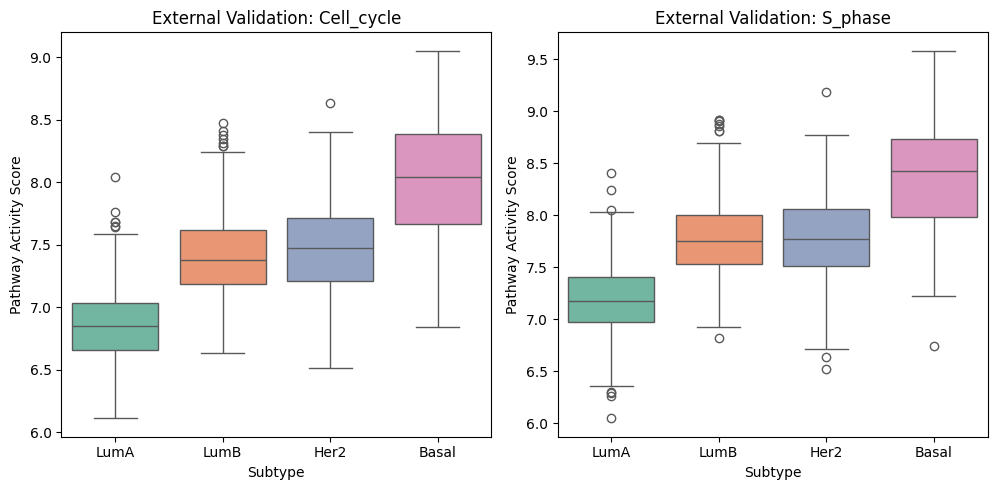

<Figure size 1000x800 with 0 Axes>

In [ ]:
plot_pathways = ["Cell_cycle", "S_phase", "ATR_Response", "G2_M_Checkpoint"]

plt.figure(figsize=(20, 5))
for i, pname in enumerate(plot_pathways):
    if pname in pathway_scores.columns:
        plt.subplot(1, 4, i+1)
        sns.boxplot(x='Subtype', y=pname, data=pathway_scores, palette="Set2")
        plt.title(f"External Validation: {pname}")
        plt.ylabel("Pathway Activity Score")
        plt.xlabel("Subtype")

plt.tight_layout()
plt.savefig("metabric_pathway_validation.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 8))
subtype_colors =  df_merged['Subtype'].map({
    'Basal': '#E74C3C', 'Her2': '#8E44AD',
    'LumA': '#3498DB', 'LumB': '#2ECC71'
})